/tmp/ipykernel_30276/1186490444.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


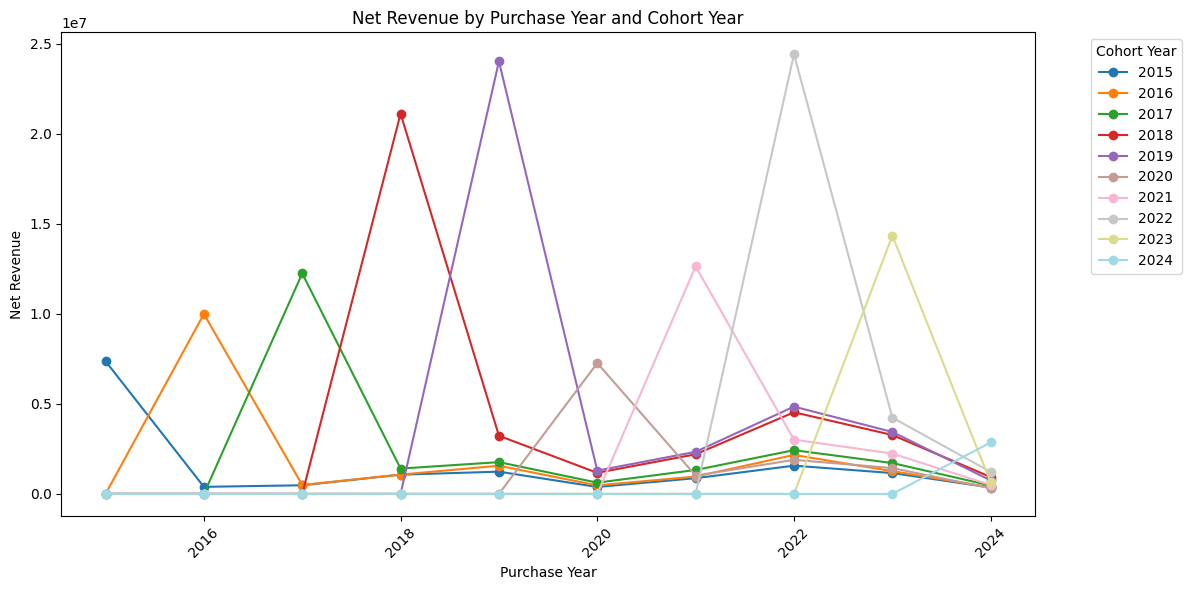

/tmp/ipykernel_30276/1186490444.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


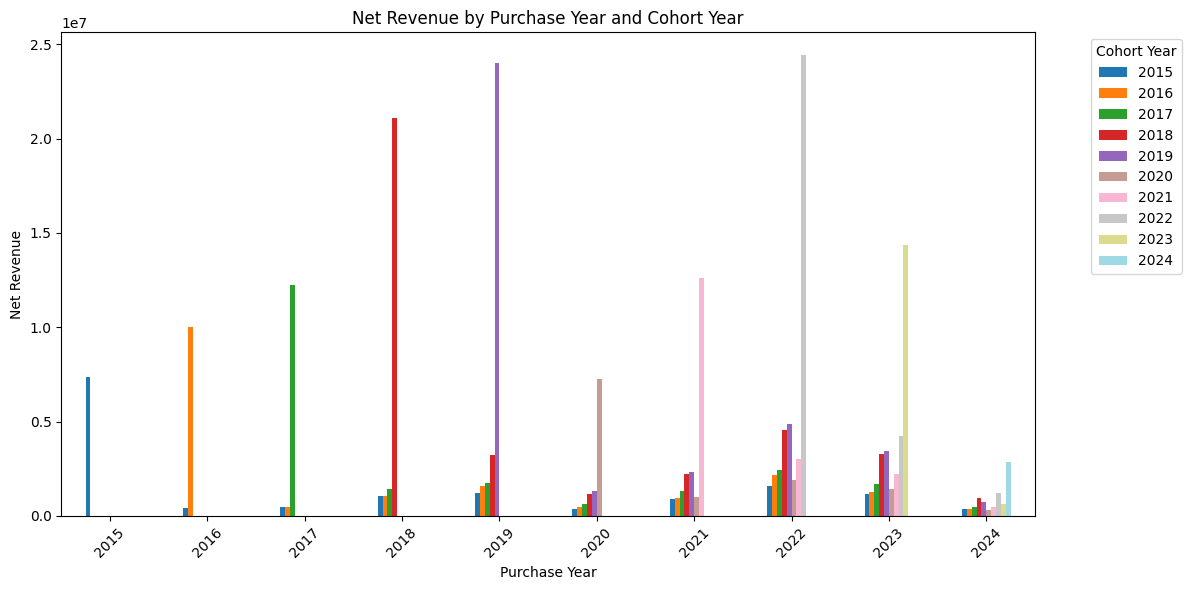

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

def run_query_and_plot(query, chart_type="line", stacked=False, db="contoso_100k", user="postgres", password="password", host="localhost", port="5432"):
    """
    Run a SQL query against PostgreSQL, pivot results by (purchase_year, cohort_year),
    and plot as either line or bar chart.
    """
    # --- Connect ---
    conn = psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port)

    # --- Fetch into pandas ---
    df = pd.read_sql_query(query, conn)
    conn.close()

    # --- Ensure proper types ---
    df["cohort_year"] = df["cohort_year"].astype(int)
    df["purchase_year"] = df["purchase_year"].astype(int)

    # --- Pivot: rows = purchase_year, cols = cohort_year ---
    pivot_df = df.pivot(index="purchase_year", columns="cohort_year", values="net_revenue").fillna(0)
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)

    # --- Plot ---
    if chart_type == "line":
        ax = pivot_df.plot(kind="line", marker="o", figsize=(12, 6), colormap="tab20")
    elif chart_type == "bar":
        ax = pivot_df.plot(kind="bar", stacked=stacked, figsize=(12, 6), colormap="tab20")
    else:
        raise ValueError("chart_type must be 'line' or 'bar'")

    # --- Style ---
    ax.set_title("Net Revenue by Purchase Year and Cohort Year")
    ax.set_xlabel("Purchase Year")
    ax.set_ylabel("Net Revenue")
    ax.legend(title="Cohort Year", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Example usage ---
query = """
WITH yearly_cohort AS (
    SELECT DISTINCT customerkey,
        EXTRACT(YEAR FROM (MIN(orderdate) OVER(PARTITION BY customerkey))) AS cohort_year
    FROM sales
)
SELECT 
    y.cohort_year,
    EXTRACT(YEAR FROM orderdate) AS purchase_year,
    SUM(s.quantity * s.netprice * s.exchangerate) AS net_revenue
FROM sales s 
LEFT JOIN yearly_cohort y ON s.customerkey = y.customerkey
GROUP BY y.cohort_year, EXTRACT(YEAR FROM orderdate)
ORDER BY y.cohort_year, purchase_year;
"""

# Line chart
run_query_and_plot(query, chart_type="line")

# Bar chart
run_query_and_plot(query, chart_type="bar")

# Stacked bar chart
#run_query_and_plot(query, chart_type="bar", stacked=True)
